In [ ]:
# Final Project 

In [1]:
# Imports

from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [5]:
cd ..

/Users/jilliangreen/Documents/DS_1030/data1030_student_f20/1030_Final_Project


In [6]:
# Files

# DATASET
df_athlete_events = pd.read_csv('data/Athlete_Info/athlete_events.csv')

# REGIONS
df_noc_regions = pd.read_csv('data/Athlete_Info/noc_regions.csv')

# POPULATION
df_world_pop = pd.read_csv('data/WorldPopulation.csv')
print(len(df_world_pop))
# drop unwanted columns 
df_world_pop = df_world_pop.drop(["Indicator Name","Indicator Code","Unnamed: 61"],axis=1)
# Pivot population table
df_world_pop = df_world_pop.melt(id_vars=["Country", "Country Code"], 
        var_name="Year", 
        value_name="Population")
df_world_pop['Year']=df_world_pop['Year'].astype(int)



217


In [7]:
# target variable

df_athlete_events[['winner']] = df_athlete_events[['Medal']].where(df_athlete_events[['Medal']].isnull(), 1).fillna(0).astype(int)
    

In [8]:
# group by feature

df_athlete_events['Event_by_Year'] = df_athlete_events['Year'].astype(str) + ' '  + df_athlete_events['Event']

In [9]:
# merges

# dataset + population
df_olympics = df_athlete_events.merge(df_world_pop, left_on = ["NOC","Year"], right_on = ["Country Code","Year"], how = 'left')
#df_olympics['Population'] = df_olympics['Value'].apply(lambda x: '%.5f' % x)

#df_olympics['Population']=df_olympics['Value'].astype(int)

# dataset + regions
df_olympics = df_olympics.merge(df_noc_regions, left_on = 'NOC', right_on = 'NOC', how = 'left')
df_olympics.head(5)


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Sport,Event,Medal,winner,Event_by_Year,Country,Country Code,Population,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,...,Basketball,Basketball Men's Basketball,NaN,0,1992 Basketball Men's Basketball,China,CHN,1.164970e+09,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,...,Judo,Judo Men's Extra-Lightweight,NaN,0,2012 Judo Men's Extra-Lightweight,China,CHN,1.350695e+09,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,...,Football,Football Men's Football,NaN,0,1920 Football Men's Football,NaN,NaN,NaN,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,...,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,1,1900 Tug-Of-War Men's Tug-Of-War,NaN,NaN,NaN,Denmark,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,...,Speed Skating,Speed Skating Women's 500 metres,NaN,0,1988 Speed Skating Women's 500 metres,NaN,NaN,NaN,Netherlands,NaN


In [10]:
# Clean the data

## Columns w/ NaNs: Age, Weight, Height, Medal
df_olympics['Medal'].fillna('DNW', inplace = True)


# other thoughts:

# Moskva should be Moskow
# Athina should be Athens

# update some incorrect country names
#1. SGP - Singapore
#2. ROT - Refugee Olympic Athletes
#3. UNK - Unknown
#4. TUV - Tuvalu

# # mulitple golds across teams
# 1. Gymnastics Women's Balance Beam
# 2. Gymnastics Men's Horizontal Bar
# 3. Swimming Women's 100 metres Freestyle
# 4. Swimming Men's 50 metres Freestyle

In [11]:
# Count medals Won
df_olympics['Medal_Won'] = np.where(df_olympics.loc[:,'Medal'] == 'DNW', 0, 1)

# identify list of team events, we define this as events where Gold wins per team/year/event are > 1

identify_team_events = pd.pivot_table(df_olympics,
                                      index = ['Team', 'Year', 'Event'], # group by
                                      columns = 'Medal', # group by
                                      values = 'Medal_Won', # sum
                                      aggfunc = 'sum',
                                      fill_value = 0).drop('DNW', axis = 1).reset_index()

# Filter for Gold > 1 since every event will have a gold winner (could do same for silver/bronze)
identify_team_events = identify_team_events.loc[identify_team_events['Gold'] > 1, :]

list_team_sports = identify_team_events['Event'].unique()

# Create single vs team event
team_event_marker = df_olympics['Event'].map(lambda x: x in list_team_sports)
single_event_marker = [not i for i in team_event_marker]

# rows where medal_won is 1
medal_marker = df_olympics['Medal_Won'] == 1

# Put 1 under team event if medal is won and event in team event list
df_olympics['Team_Event'] = np.where(team_event_marker & medal_marker, 1, 0)

# Put 1 under singles event if medal is won and event not in team event list
df_olympics['Single_Event'] = np.where(single_event_marker & medal_marker, 1, 0)

# Add an identifier for team/single event
df_olympics['Event_Category'] = df_olympics['Single_Event'] + \
df_olympics['Team_Event']

# Create DF that shows corrected medals won per year/team/event
medal_tally_agnostic = df_olympics.groupby(['Year', 'Team', 'Event', 'Medal'])[['Medal_Won', 'Event_Category']].agg('sum').reset_index()
medal_tally_agnostic['Medal_Won_Corrected'] = medal_tally_agnostic['Medal_Won']/medal_tally_agnostic['Event_Category']

In [12]:
# Find wins by athlete

df_wins_by_name = df_olympics.filter(items=["ID","Medal"])

df_wins_by_name = df_wins_by_name.groupby(["ID", "Medal"])["Medal"].count().reset_index(name="count").sort_values('ID')

df_wins_by_name = pd.pivot_table(df_wins_by_name,
                                      index = ['ID'], # group by
                                      columns = 'Medal', # group by
                                      values = 'count', # sum
                                      aggfunc = 'sum',
                                      fill_value = 0).reset_index()

column_list = ['Bronze', 'Gold', 'Silver']
df_wins_by_name["Total_Medals"] = df_wins_by_name[column_list].sum(axis=1)


In [13]:
# dataset + total medals adjusted
df_olympics = df_olympics.merge(medal_tally_agnostic, left_on = ["Year","Team","Event","Medal"], right_on = ["Year","Team","Event","Medal"], how = 'left').drop(columns = ['Medal_Won_x', 'Event_Category_x'], axis=1) 

# dataset + wins by athlete
df_olympics = df_olympics.merge(df_wins_by_name, left_on = ["ID"], right_on = ["ID"], how = 'left')

print(len(df_olympics))
df_olympics.head(10)

271116


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Team_Event,Single_Event,Medal_Won_y,Event_Category_y,Medal_Won_Corrected,Bronze,DNW,Gold,Silver,Total_Medals
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,...,0,0,0,0,NaN,0,1,0,0,0
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,...,0,0,0,0,NaN,0,1,0,0,0
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,...,0,0,0,0,NaN,0,1,0,0,0
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,...,1,0,6,6,1.0,0,0,1,0,1
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,...,0,0,0,0,NaN,0,6,0,0,0
5,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,...,0,0,0,0,NaN,0,6,0,0,0
6,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,...,0,0,0,0,NaN,0,6,0,0,0
7,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,...,0,0,0,0,NaN,0,6,0,0,0
8,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,...,0,0,0,0,NaN,0,6,0,0,0
9,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,...,0,0,0,0,NaN,0,6,0,0,0


In [14]:
# More data cleaning

df_olympics['Medal_Won_Corrected'].fillna(0, inplace = True)
df_olympics['Medal_Won_y'].fillna(0, inplace = True)
df_olympics = df_olympics.drop(['notes'], 1)

In [15]:
# New df for gold wins only

df_olympics_gold = df_olympics[df_olympics["Gold"] >1]
# year of start of ??? olympics
df_olympics_gold = df_olympics_gold[df_olympics_gold["Year"] >= 1924]
print(len(df_olympics_gold))
df_olympics_gold.head(10)

9388


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Team_Event,Single_Event,Medal_Won_y,Event_Category_y,Medal_Won_Corrected,Bronze,DNW,Gold,Silver,Total_Medals
41,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,...,0,1,1,1,1.0,2,11,3,0,5
42,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,...,1,0,8,8,1.0,2,11,3,0,5
43,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,...,0,0,0,0,0.0,2,11,3,0,5
44,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,...,1,0,1,1,1.0,2,11,3,0,5
45,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,...,0,0,0,0,0.0,2,11,3,0,5
46,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,...,0,0,0,0,0.0,2,11,3,0,5
47,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,...,0,0,0,0,0.0,2,11,3,0,5
48,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,...,1,0,3,3,1.0,2,11,3,0,5
49,17,Paavo Johannes Aaltonen,M,32.0,175.0,64.0,Finland,FIN,1952 Summer,1952,...,0,0,0,0,0.0,2,11,3,0,5
50,17,Paavo Johannes Aaltonen,M,32.0,175.0,64.0,Finland,FIN,1952 Summer,1952,...,1,0,8,8,1.0,2,11,3,0,5


In [16]:
df_olympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Team_Event,Single_Event,Medal_Won_y,Event_Category_y,Medal_Won_Corrected,Bronze,DNW,Gold,Silver,Total_Medals
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,...,0,0,0,0,0.0,0,1,0,0,0
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,...,0,0,0,0,0.0,0,1,0,0,0
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,...,0,0,0,0,0.0,0,1,0,0,0
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,...,1,0,6,6,1.0,0,0,1,0,1
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,...,0,0,0,0,0.0,0,6,0,0,0


# EDA

#### Observations
- summing medal column would be incorrect wins since doesn't account for team wins

In [21]:
print(df_olympics.dtypes)

ID                       int64
Name                    object
Sex                     object
Age                    float64
Height                 float64
Weight                 float64
Team                    object
NOC                     object
Games                   object
Year                     int64
Season                  object
City                    object
Sport                   object
Event                   object
Medal                   object
winner                   int64
Event_by_Year           object
Country                 object
Country Code            object
Population             float64
region                  object
Team_Event               int64
Single_Event             int64
Medal_Won_y              int64
Event_Category_y         int64
Medal_Won_Corrected    float64
Bronze                   int64
DNW                      int64
Gold                     int64
Silver                   int64
Total_Medals             int64
dtype: object


# Categorical Features
value_counts()

### Sex

In [22]:
print(df_olympics['Sex'].value_counts())

M    196594
F     74522
Name: Sex, dtype: int64


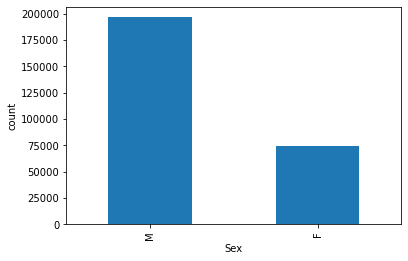

In [23]:
pd.value_counts(df_olympics['Sex']).plot.bar()
plt.ylabel('count')
plt.xlabel('Sex')
plt.show()

### Team

In [24]:
print(df_olympics['Team'].value_counts())

United States       17847
France              11988
Great Britain       11404
Italy               10260
Germany              9326
                    ...  
Mignon-29               1
Demi-Mondaine-17        1
Brynhild-2              1
Breslau                 1
Femur-18                1
Name: Team, Length: 1184, dtype: int64


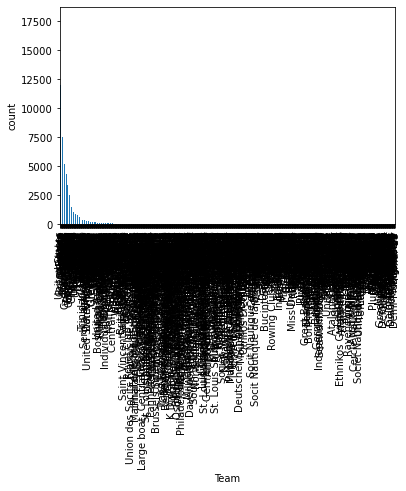

In [25]:
pd.value_counts(df_olympics['Team']).plot.bar()
plt.ylabel('count')
plt.xlabel('Team')
plt.show()

### Year

In [26]:
print(df_olympics['Year'].value_counts())

1992    16413
1988    14676
2000    13821
1996    13780
2016    13688
2008    13602
2004    13443
2012    12920
1972    11959
1984    11588
1976    10502
1968    10479
1964     9480
1952     9358
1960     9235
1980     8937
1948     7480
1936     7401
1956     6434
1924     5693
1928     5574
2014     4891
2010     4402
2006     4382
1920     4292
2002     4109
1912     4040
1998     3605
1932     3321
1994     3160
1908     3101
1900     1936
1906     1733
1904     1301
1896      380
Name: Year, dtype: int64


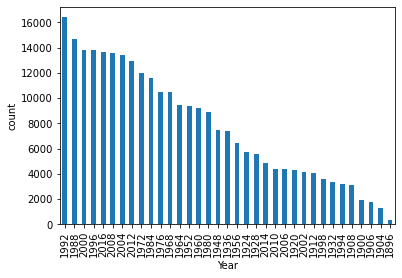

In [27]:
pd.value_counts(df_olympics['Year']).plot.bar()
plt.ylabel('count')
plt.xlabel('Year')
plt.show()

### Season

In [28]:
print(df_olympics['Season'].value_counts())

Summer    222552
Winter     48564
Name: Season, dtype: int64


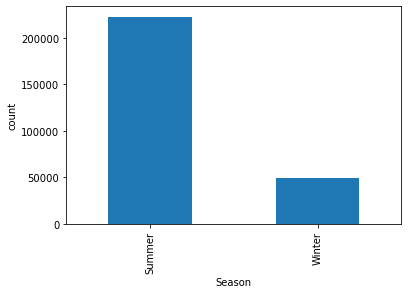

In [29]:
pd.value_counts(df_olympics['Season']).plot.bar()
plt.ylabel('count')
plt.xlabel('Season')
plt.show()

### City

In [30]:
print(df_olympics['City'].value_counts())

London                    22426
Athina                    15556
Sydney                    13821
Atlanta                   13780
Rio de Janeiro            13688
Beijing                   13602
Barcelona                 12977
Los Angeles               12423
Seoul                     12037
Munich                    10304
Montreal                   8641
Mexico City                8588
Helsinki                   8270
Roma                       8119
Tokyo                      7702
Moskva                     7191
Paris                      7169
Berlin                     6506
Amsterdam                  4992
Sochi                      4891
Melbourne                  4829
Vancouver                  4402
Torino                     4382
Stockholm                  4338
Antwerpen                  4292
Salt Lake City             4109
Innsbruck                  3639
Nagano                     3605
Albertville                3436
Lillehammer                3160
Calgary                    2639
Sarajevo

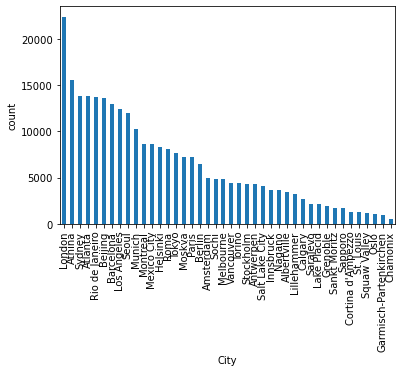

In [31]:
pd.value_counts(df_olympics['City']).plot.bar()
plt.ylabel('count')
plt.xlabel('City')
plt.show()

### Sport

In [32]:
print(df_olympics['Sport'].value_counts())

Athletics        38624
Gymnastics       26707
Swimming         23195
Shooting         11448
Cycling          10859
                 ...  
Racquets            12
Jeu De Paume        11
Roque                4
Basque Pelota        2
Aeronautics          1
Name: Sport, Length: 66, dtype: int64


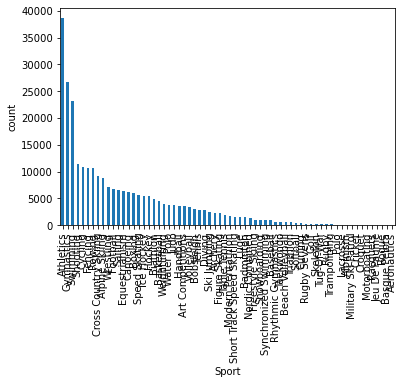

In [33]:
pd.value_counts(df_olympics['Sport']).plot.bar()
plt.ylabel('count')
plt.xlabel('Sport')
plt.show()

### Medal

In [34]:
print(df_olympics['Medal'].value_counts())

DNW       231333
Gold       13372
Bronze     13295
Silver     13116
Name: Medal, dtype: int64


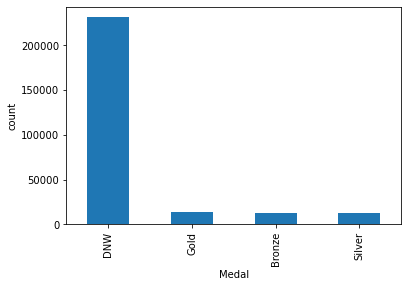

In [35]:
pd.value_counts(df_olympics['Medal']).plot.bar()
plt.ylabel('count')
plt.xlabel('Medal')
plt.show()

### Event

In [36]:
print(df_olympics['Event'].value_counts())

Football Men's Football                                5733
Ice Hockey Men's Ice Hockey                            4762
Hockey Men's Hockey                                    3958
Water Polo Men's Water Polo                            3358
Basketball Men's Basketball                            3280
                                                       ... 
Archery Men's Target Archery, 28 metres, Individual       2
Archery Men's Target Archery, 33 metres, Individual       2
Basque Pelota Men's Two-Man Teams With Cesta              2
Croquet Mixed Doubles                                     2
Aeronautics Mixed Aeronautics                             1
Name: Event, Length: 765, dtype: int64


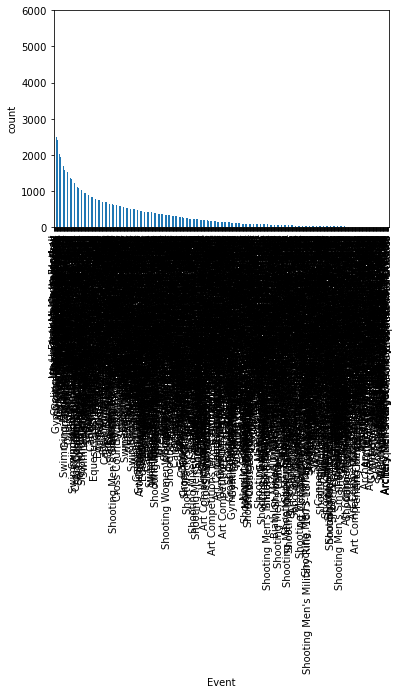

In [37]:
pd.value_counts(df_olympics['Event']).plot.bar()
plt.ylabel('count')
plt.xlabel('Event')
plt.show()

### Winner

In [38]:
print(df_olympics['winner'].value_counts())

0    231333
1     39783
Name: winner, dtype: int64


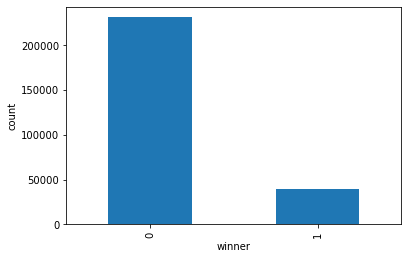

In [39]:
pd.value_counts(df_olympics['winner']).plot.bar()
plt.ylabel('count')
plt.xlabel('winner')
plt.show()

# Continuous Features

.describe()

### Age

In [40]:
print(df_olympics['Age'].describe())

count    261642.000000
mean         25.556898
std           6.393561
min          10.000000
25%          21.000000
50%          24.000000
75%          28.000000
max          97.000000
Name: Age, dtype: float64


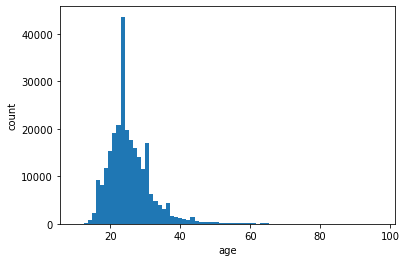

In [41]:
df_olympics['Age'].plot.hist(bins = df_olympics['Age'].nunique())
plt.xlabel('age')
plt.ylabel('count')
plt.show()

### Height

In [42]:
print(df_olympics['Height'].describe())

count    210945.000000
mean        175.338970
std          10.518462
min         127.000000
25%         168.000000
50%         175.000000
75%         183.000000
max         226.000000
Name: Height, dtype: float64


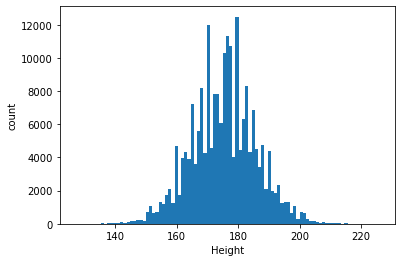

In [43]:
df_olympics['Height'].plot.hist(bins = df_olympics['Height'].nunique())
plt.xlabel('Height')
plt.ylabel('count')
plt.show()

### Weight

In [44]:
print(df_olympics['Weight'].describe())

count    208241.000000
mean         70.702393
std          14.348020
min          25.000000
25%          60.000000
50%          70.000000
75%          79.000000
max         214.000000
Name: Weight, dtype: float64


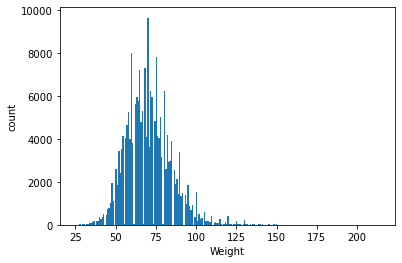

In [45]:
df_olympics['Weight'].plot.hist(bins = df_olympics['Weight'].nunique())
plt.xlabel('Weight')
plt.ylabel('count')
plt.show()

### Population

In [46]:
print(df_olympics['Population'].describe())

count    1.519310e+05
mean     1.053882e+08
std      2.374409e+08
min      1.003300e+04
25%      1.025506e+07
50%      3.794802e+07
75%      6.565979e+07
max      1.378665e+09
Name: Population, dtype: float64


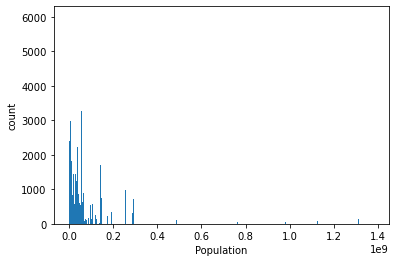

In [47]:
df_olympics['Population'].plot.hist(bins = df_olympics['Population'].nunique())
plt.xlabel('Population')
plt.ylabel('count')
plt.show()

# Visualizations

In [48]:
### TYPES OF VISUALIZATIONS FOR REFERENCE

# # Scatter: Continuous vs. Continuous
# df.plot.scatter('age','hours-per-week',s=10,alpha=0.1) # alpha=0.1,s=10
# plt.show()

# # Heatmap: Continuous vs. Continuous
# nbins = 20
# heatmap, xedges, yedges = np.histogram2d(df['age'], df['hours-per-week'], bins=nbins)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# plt.imshow(np.log10(heatmap).T, origin='lower') # use log count
# plt.xlabel('age')
# plt.ylabel('hours-per-week')
# plt.xticks(np.arange(nbins)[::int(nbins/4)],xedges[::int(nbins/4)].astype(int))
# plt.yticks(np.arange(nbins)[::int(nbins/4)],yedges[::int(nbins/4)].astype(int))
# plt.colorbar(label='log10(count)')
# plt.show()

# # Stacked Bar: Categorical vs Categorical
# count_matrix = df.groupby(['race', 'gross-income']).size().unstack()
# #print(count_matrix)
# count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
# print(count_matrix_norm)
# count_matrix_norm.plot(kind='bar', stacked=True)
# plt.ylabel('fraction of people in group')
# plt.legend(loc=4)
# plt.show()

# # Category specific histograms: continuous vs. categorical 
# categories = df['gross-income'].unique()
# bin_range = (df['age'].min(),df['age'].max())
# for c in categories:
#     plt.hist(df[df['gross-income']==c]['age'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
# plt.legend()
# plt.ylabel('counts')
# plt.xlabel('age')
# plt.show()

# # Box plot: continuous vs. categorical
# df[['age','gross-income']].boxplot(by='gross-income')
# plt.ylabel('age')
# plt.show()

# # Violin plot: continuous vs. categorical 
# dataset = [df[df['gross-income']==' <=50K']['age'].values,
#            df[df['gross-income']==' >50K']['age'].values]

# plt.violinplot(dataset = dataset)
# plt.xticks([1,2],['<=50k','>50k'])
# plt.ylabel('age')
# plt.show()

winner         0         1
NOC                       
URS     0.559719  0.440281
GDR     0.620038  0.379962
ANZ     0.662791  0.337209
EUN     0.677083  0.322917
USA     0.701002  0.298998
WIF     0.750000  0.250000
RUS     0.773479  0.226521
GER     0.779756  0.220244
SRB     0.783163  0.216837
PAK     0.784698  0.215302
NOR     0.791734  0.208266
SCG     0.800623  0.199377
CHN     0.807625  0.192375
JAM     0.814858  0.185142
SWE     0.815805  0.184195
NED     0.821887  0.178113
FRG     0.823228  0.176772
AUS     0.827180  0.172820
HUN     0.828213  0.171787
CRO     0.829909  0.170091
GBR     0.831266  0.168734
DEN     0.832773  0.167227
CUB     0.835014  0.164986
FIN     0.835376  0.164624
AZE     0.844523  0.155477
ITA     0.847224  0.152776
YUG     0.849013  0.150987
MNE     0.851064  0.148936
ROU     0.851759  0.148241
KOR     0.857079  0.142921


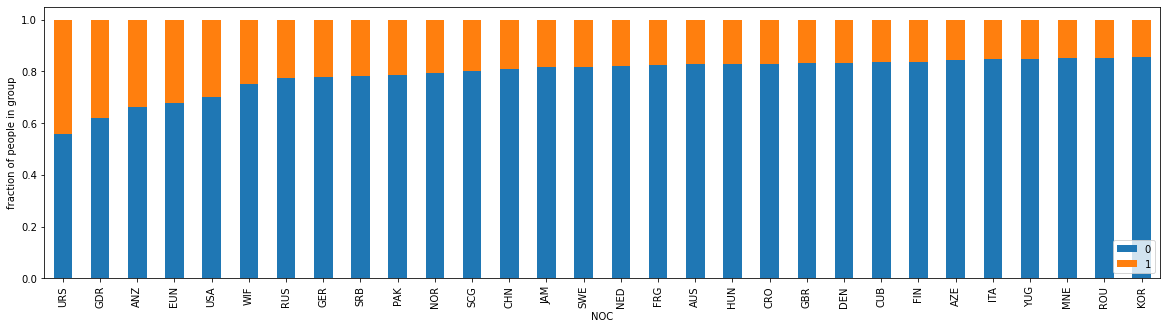

In [49]:
txt = ""

# Stacked Bar: Categorical vs Categorical
count_matrix = df_olympics.groupby(['NOC', 'winner']).size().unstack()
#print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0).sort_values(by=1,ascending=False).head(30)
print(count_matrix_norm)
count_matrix_norm.plot(kind='bar', stacked=True)
plt.ylabel('fraction of people in group')
plt.legend(loc=4)
fig = plt.gcf()
fig.text(.5, -0.1, txt, ha='center')
fig.set_size_inches(20, 5)
plt.show()

/Users/jilliangreen/anaconda3/envs/data1030/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jilliangreen/anaconda3/envs/data1030/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


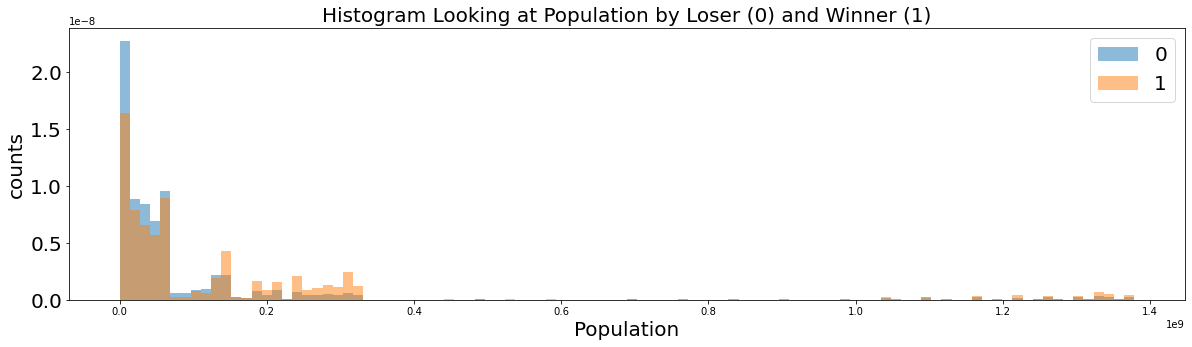

In [50]:
txt = ""

# Category specific histograms: continuous vs. categorical 
categories = df_olympics['winner'].unique()
bin_range = (df_olympics['Population'].min(),df_olympics['Population'].max())
for c in categories:
    plt.hist(df_olympics[df_olympics['winner']==c]['Population'],alpha=0.5,label=c,range=bin_range,bins=100,density=True)
plt.legend(fontsize= 20)
plt.yticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('counts',fontsize= 20)
plt.xlabel('Population',fontsize= 20)
plt.title("Histogram Looking at Population by Loser (0) and Winner (1)", fontsize= 20)
fig = plt.gcf()
fig.text(.5, -0.1, txt, ha='center')
fig.set_size_inches(20, 5)
plt.show()

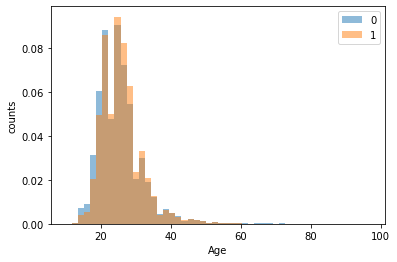

In [51]:
# Category specific histograms: continuous vs. categorical 
categories = df_olympics['winner'].unique()
bin_range = (df_olympics['Age'].min(),df_olympics['Age'].max())
for c in categories:
    plt.hist(df_olympics[df_olympics['winner']==c]['Age'],alpha=0.5,label=c,range=bin_range,bins=50,density=True)
plt.legend()
plt.ylabel('counts')
plt.xlabel('Age')
plt.show()

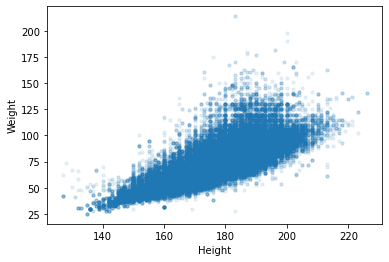

In [52]:
# Scatter: Continuous vs. Continuous
df_olympics.plot.scatter('Height','Weight',s=10,alpha=0.1) # alpha=0.1,s=10
plt.show()

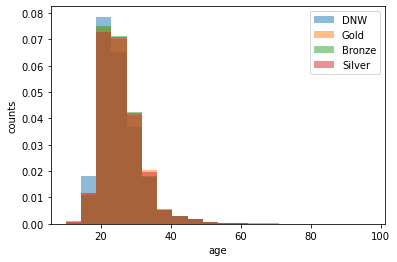

In [53]:
# Category specific histograms: continuous vs. categorical 
categories = df_olympics['Medal'].unique()
bin_range = (df_olympics['Age'].min(),df_olympics['Age'].max())
for c in categories:
    plt.hist(df_olympics[df_olympics['Medal']==c]['Age'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('counts')
plt.xlabel('age')
plt.show()


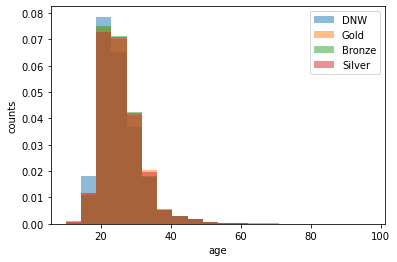

In [54]:
# Category specific histograms: continuous vs. categorical 
categories = df_olympics['Medal'].unique()
bin_range = (df_olympics['Age'].min(),df_olympics['Age'].max())
for c in categories:
    plt.hist(df_olympics[df_olympics['Medal']==c]['Age'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('counts')
plt.xlabel('age')
plt.show()


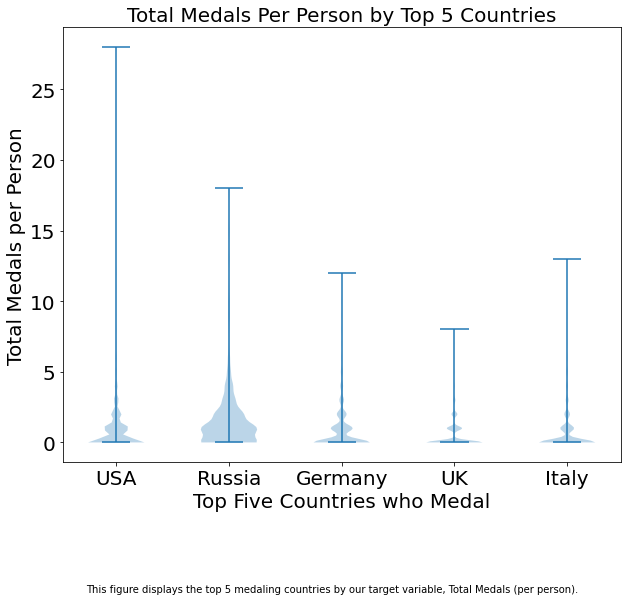

In [55]:
top_country_list = ['USA','URS','GER','GBR','ITA']

df_olympics_top_countries = df_olympics
df_olympics_top_countries = df_olympics_top_countries[(df_olympics_top_countries["NOC"] == 'USA') | (df_olympics_top_countries["NOC"] == 'URS') | (df_olympics_top_countries["NOC"] == 'GER') | (df_olympics_top_countries["NOC"] == 'GBR') | (df_olympics_top_countries["NOC"] == 'ITA')]


txt="This figure displays the top 5 medaling countries by our target variable, Total Medals (per person)."


# Violin plot: continuous vs. categorical 
dataset = [df_olympics_top_countries[df_olympics_top_countries['NOC']=='USA']['Total_Medals'].values,
           df_olympics_top_countries[df_olympics_top_countries['NOC']=='URS']['Total_Medals'].values,
           df_olympics_top_countries[df_olympics_top_countries['NOC']=='GER']['Total_Medals'].values,
           df_olympics_top_countries[df_olympics_top_countries['NOC']=='GBR']['Total_Medals'].values,
           df_olympics_top_countries[df_olympics_top_countries['NOC']=='ITA']['Total_Medals'].values]

plt.violinplot(dataset = dataset)
plt.xticks([1,2,3,4,5],['USA','Russia','Germany','UK','Italy'], fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Total Medals per Person', fontsize=20)
plt.xlabel('Top Five Countries who Medal', fontsize=20)
plt.title('Total Medals Per Person by Top 5 Countries', fontsize=20)
fig = plt.gcf()
fig.text(.5, -0.1, txt, ha='center')
fig.set_size_inches(10, 8)
plt.show()


winner         0         1
Sex                       
F       0.762828  0.237172
M       0.752905  0.247095


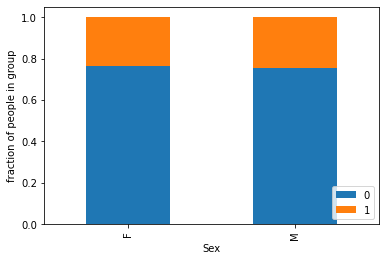

In [56]:
# Stacked Bar: Categorical vs Categorical
count_matrix = df_olympics_top_countries.groupby(['Sex', 'winner']).size().unstack()
#print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
print(count_matrix_norm)
count_matrix_norm.plot(kind='bar', stacked=True)
plt.ylabel('fraction of people in group')
plt.legend(loc=4)
plt.show()

Medal    Bronze       DNW      Gold    Silver
NOC                                          
ANZ    0.058140  0.662791  0.232558  0.046512
URS    0.121196  0.559719  0.190325  0.128760
GDR    0.106238  0.620038  0.150095  0.123629
EUN    0.093750  0.677083  0.146991  0.082176
USA    0.072031  0.701002  0.139925  0.087042
KOS         NaN  0.875000  0.125000       NaN
IND    0.028409  0.860085  0.098011  0.013494
NOR    0.059274  0.791734  0.076210  0.072782
RUS    0.079331  0.773479  0.075831  0.071359
GER    0.075890  0.779756  0.075788  0.068566
PAK    0.060498  0.784698  0.074733  0.080071
CHN    0.056798  0.807625  0.068080  0.067497
CRO    0.042237  0.829909  0.066210  0.061644
CUB    0.046793  0.835014  0.066156  0.052037
HUN    0.056153  0.828213  0.065385  0.050250
CMR    0.003205  0.929487  0.064103  0.003205
ETH    0.058201  0.859788  0.058201  0.023810
SWE    0.064156  0.815805  0.057441  0.062597
FIJ         NaN  0.943966  0.056034       NaN
GBR    0.053117  0.831266  0.05532

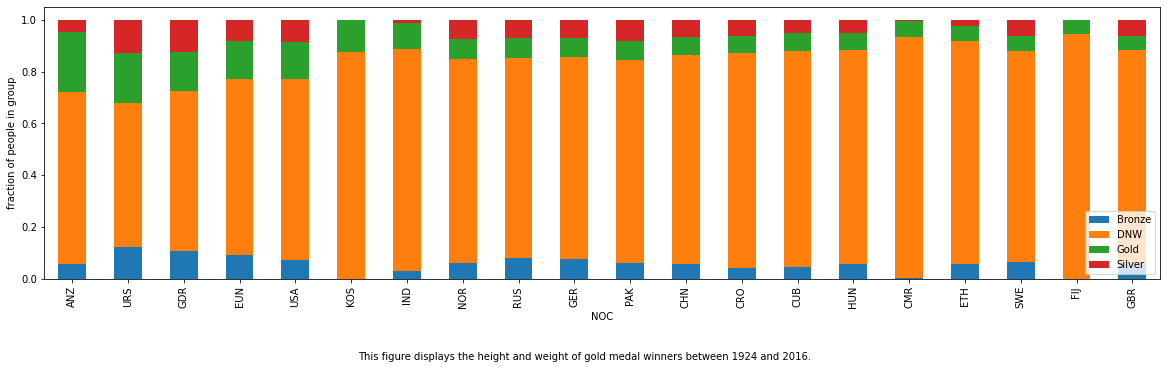

In [57]:
# Stacked Bar: Categorical vs Categorical

txt="This figure displays the height and weight of gold medal winners between 1924 and 2016."

count_matrix = df_olympics.groupby(['NOC', 'Medal']).size().unstack()
#print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0).sort_values(by='Gold',ascending=False).head(20)
print(count_matrix_norm)
count_matrix_norm.plot(kind='bar', stacked=True)
plt.ylabel('fraction of people in group')
plt.legend(loc=4)
fig = plt.gcf()
fig.text(.5, -0.1, txt, ha='center')
fig.set_size_inches(20, 5)
plt.show()

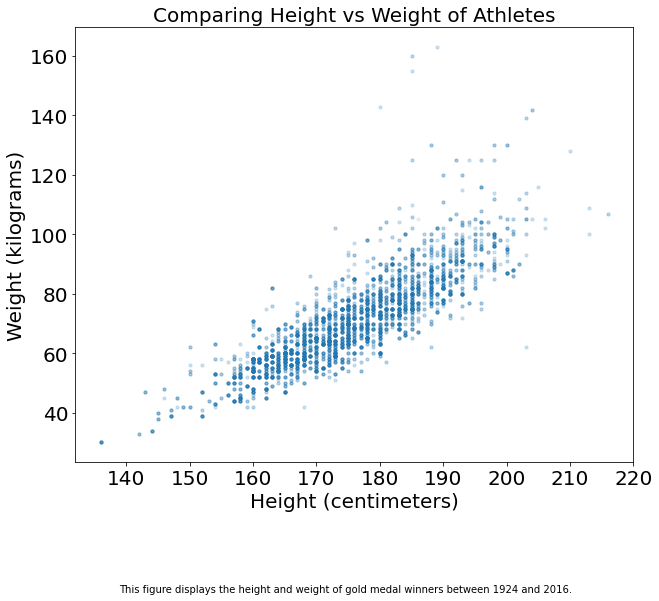

In [59]:
# Scatter: Continuous vs. Continuous

txt="This figure displays the height and weight of gold medal winners between 1924 and 2016."

df_olympics_gold.plot.scatter('Height','Weight',s=10,alpha=0.1) # alpha=0.1,s=10
#plt.set_size_inches(8, 5)
plt.xlabel('Height (centimeters)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Weight (kilograms)', fontsize=20)
plt.title("Comparing Height vs Weight of Athletes",fontsize=20)
fig = plt.gcf()
fig.text(.5, -0.1, txt, ha='center')
fig.set_size_inches(10, 8)
plt.show()

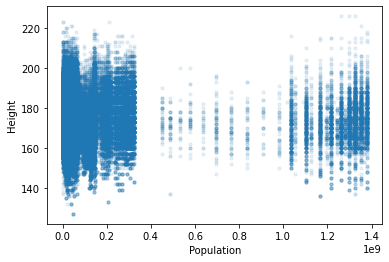

In [60]:
# Scatter: Continuous vs. Continuous
df_olympics.plot.scatter('Population','Height',s=10,alpha=0.1) # alpha=0.1,s=10
plt.show()

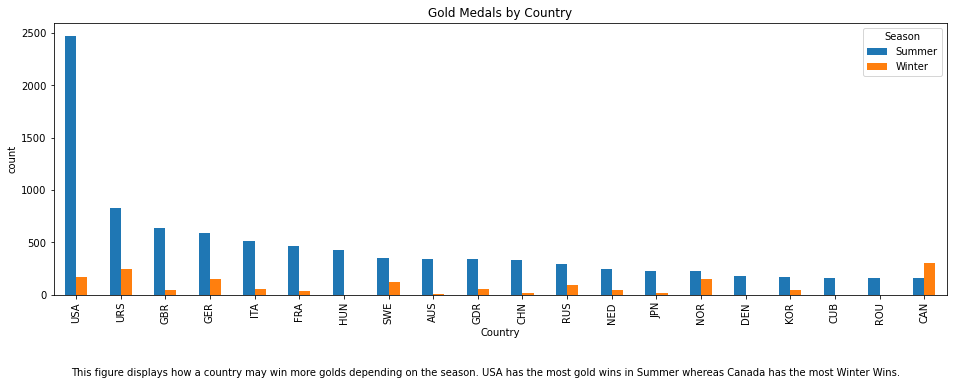

In [61]:
txt="This figure displays how a country may win more golds depending on the season. USA has the most gold wins in Summer whereas Canada has the most Winter Wins."

c_medal=df_olympics[df_olympics['Medal']=='Gold'].groupby(['NOC','Season'])['Sex'].count().reset_index()
c_medal=c_medal.pivot('NOC','Season','Sex').fillna(0).sort_values(by='Summer',ascending=False).head(20)
c_medal.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('count')
plt.title('Gold Medals by Country')
fig = plt.gcf()
fig.text(.5, -0.1, txt, ha='center')
fig.set_size_inches(16, 5)
plt.show()


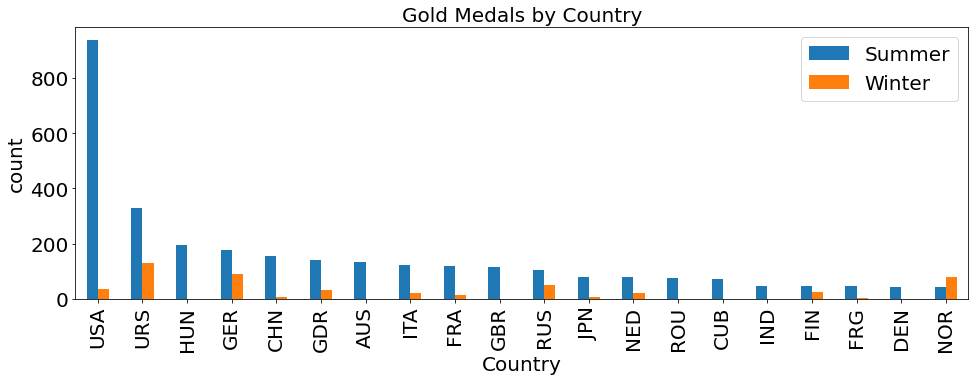

In [62]:
txt="This figure displays how a country may win more golds depending on the season. USA has the most gold wins in Summer whereas URS has the most Winter Wins."

c_medal=df_olympics_gold[df_olympics_gold['Medal']=='Gold'].groupby(['NOC','Season'])['Sex'].count().reset_index()
c_medal=c_medal.pivot('NOC','Season','Sex').fillna(0).sort_values(by='Summer',ascending=False).head(20)
c_medal.plot(kind='bar')
plt.xlabel('Country',fontsize=20)
plt.ylabel('count',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Gold Medals by Country',fontsize=20)
plt.legend(fontsize=20)
fig = plt.gcf()
#fig.text(.5, -0.1, txt, ha='center')
fig.set_size_inches(16, 5)
plt.show()


# Prep & Split

This is IID data: all samples stem from the same generative process and the generative process is assumed to have no memory of past generated samples

In [329]:
print(df_olympics.columns)
df_olympics.head(5)
print(df_olympics.dtypes)

Index(['ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games',
       'Year', 'Season', 'City', 'Sport', 'Event', 'Medal', 'region', 'notes',
       'Team_Event', 'Single_Event', 'Medal_Won_y', 'Event_Category_y',
       'Medal_Won_Corrected'],
      dtype='object')
ID                       int64
Name                    object
Sex                     object
Age                    float64
Height                 float64
Weight                 float64
Team                    object
NOC                     object
Games                   object
Year                     int64
Season                  object
City                    object
Sport                   object
Event                   object
Medal                   object
region                  object
notes                   object
Team_Event               int64
Single_Event             int64
Medal_Won_y              int64
Event_Category_y         int64
Medal_Won_Corrected    float64
dtype: object


Split by: 60% train, 20% validation, 20% test for small datasets

In [ ]:
## Helpful views
#df_olympics.isna().any()

In [ ]:

df_olympics_process = df_olympics

df_olympics_process = df_olympics_process.filter(items=['ID', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games',
       'Year', 'Season', 'City', 'Sport', 'Event', 'Medal', 'Country',
       'Country Code', 'Value', 'Population',
       'Medal_Won_Corrected', 'Bronze', 'DNW', 'Gold', 'Silver',
       'Total_Medals','winner','Event_by_Year'])

from sklearn.model_selection import GroupShuffleSplit
    
# Make code reproducable by setting seed
np.random.seed(18)

# Create list of random states to loop through
random_states = [3] #,18,27,1963,120,114,302,407,423,1201]
    
y = df_olympics_process['winner']                # target column
X = df_olympics_process.drop(["winner"], axis=1) # all other columns are features
groups = df_olympics_process['Event_by_Year']                     # group by Name of Country
    
for random_state in random_states:

    print("\n\nFor random state: " + str(random_state))
    
    # Split dataset into train and other
    gss = GroupShuffleSplit(n_splits=1, train_size=.6, random_state=random_state)
    for train_idx, other_idx in gss.split(X, y, groups):
        X_train = X.iloc[train_idx]
        X_other = X.iloc[other_idx]
        y_train = y.iloc[train_idx]
        y_other = y.iloc[other_idx]
        
        #print("\nTraining set: ", X_train.shape, y_train.shape)
    
        # Split Other into Val and Test
        gss2 = GroupShuffleSplit(n_splits=1, train_size=.5, random_state=random_state)
        groups_other = X_other[["Event_by_Year"]]
        for val_idx, test_idx in gss2.split(X_other, y_other, groups_other):
            X_val = X_other.iloc[val_idx]
            X_test = X_other.iloc[test_idx]
            y_val = y_other.iloc[val_idx]
            y_test = y_other.iloc[test_idx]

        print("\Train set: ", X_train.shape, y_train.shape)
        print("\Test set: ", X_test.shape, y_test.shape)
        print("\Val set: ", X_val.shape, y_val.shape)

        # Preprocess
        # Collect which encoder to use on each feature
        ordinal_ftrs = ['Medal'] 
        ordinal_cats = [['DNW','Bronze','Silver','Gold']]
        onehot_ftrs = ['Sex','Team','Games','NOC','Season','City','Sport','Event'] # ordinal features w/ no rank
            # Team_Event,'Single_Event'
        minmax_ftrs = ['Age','Year'] # continuous feature w/ clear boundary 
        std_ftrs = ['Height','Weight','Population','Bronze', 'DNW', 'Gold', 'Silver','Medal_Won_Corrected'] # continuous feature w/out clear boundary 
            #Medal_Won_y


        # collect all the encoders
        preprocessor = ColumnTransformer(
            transformers=[
                ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
                ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
                ('minmax', MinMaxScaler(), minmax_ftrs),
                ('std', StandardScaler(), std_ftrs)])
        clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                               # later on we will add other steps here
        X_train_prep = clf.fit_transform(X_train)
        X_val_prep = clf.transform(X_val)
        X_test_prep = clf.transform(X_test)

        print(X_train.shape)
        print(X_train_prep.shape)
        print(X_train_prep)
        
        # the target variable still needs to be preprocessed separately
        le = LabelEncoder()
        print("printing y_val")
        print(type(y_val))
        print(y_val)

        y_train_prep = le.fit_transform(y_train)
        y_val_prep = le.transform(y_val)
        y_test_prep = le.transform(y_test)

        print("\n\nTrain Scaled Sample: ", y_train_prep)
        print("\n\nVal Scaled Sample: ", y_val_prep)
        print("\n\nTest Scaled Sample: ", y_test_prep)


In [331]:
df_olympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Sport,Event,Medal,region,notes,Team_Event,Single_Event,Medal_Won_y,Event_Category_y,Medal_Won_Corrected
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,...,Basketball,Basketball Men's Basketball,DNW,China,NaN,0,0,0,0,0.0
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,...,Judo,Judo Men's Extra-Lightweight,DNW,China,NaN,0,0,0,0,0.0
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,...,Football,Football Men's Football,DNW,Denmark,NaN,0,0,0,0,0.0
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,...,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN,1,0,6,6,1.0
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,...,Speed Skating,Speed Skating Women's 500 metres,DNW,Netherlands,NaN,0,0,0,0,0.0


In [38]:
# let's separate the feature matrix X, and target variable y
y = df_olympics['Medal'] # remember, we want to predict who earns more than 50k or less than 50k
X = df_olympics.loc[:, df_olympics.columns != 'Medal'] # all other columns are features
print(y)
print(X.head())


0          DNW
1          DNW
2          DNW
3         Gold
4          DNW
          ... 
271111     DNW
271112     DNW
271113     DNW
271114     DNW
271115     DNW
Name: Medal, Length: 271116, dtype: object
   ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 W

NOTES ABOUT DATASET 

Each row corresponds to an individuals appearnace in an Olympic event.

Introduction (5 points)
- Clearly describe the problem you want to solve. 
    - Problem: Predict if an individual will win or not, based on event and year
- What is the target variable?
    - winner
- Is the problem regression or classification?
    - classification, predict win or lose
- Why is this interesting/important?
    - Winning olympic medals creates job opportunities, increases investments (sponsorships, tourism, revenue), national pride among a country
- Number of data points and number of features.
    - 271116 datapoints, 19 features 
- If dataset is not well-documented, write a description for each feature (if feature is categorical, describe each category; if feature is numerical, include the unit of the quantity and what it measures)
    - see report
- If the dataset is from Kaggle/UCI/already described, write a short description about 2-3 public projects or publications where the data has been used, what did the authors find, what ML question did they solve and how successful they were.
    - see report


In [40]:
print("Number of datapoints: ", len(df_olympics))

Number of datapoints:  271116


Exploratory Data Analysis (15 points)
- Perform a thorough EDA on each column in your dataset and pay special attention to your target variable
    - see above, see report
- Use .describe or .value_counts, create histograms or bar plots as appropriate
    - see above, see report
- Create other type of figures using two columns
    - see above, see report
- Create a scatter matrix
    - see above, see report
- There is no need to include everything in the report.
- Choose at least three but maximum five figures that you think are interesting or important and one of those figures should show the target variable. Do not include three figures of the same type (e.g., you’ll lose points if you submit three bar plots). Use at least two figure types.
- Write a figure caption for each figure.
- Make sure your figures are publication-quality figures. Please print out your report before you submit it and make sure the figures are readable, the font size is similar to the text font size, axes are labelled, the figures have sufficient resolution (usually 300 dpi).


Data preprocessing (10 points)
- Discuss how you split the dataset and why.
- Is your dataset IID?
    - Not IID since we are grouping by year+event to predict win or loss
- Does it have group structure?
    - Yes, group by Year+Event
- Is it a time series data?
    - No
- How should you split the dataset given your ML question to best mimic future use when you deploy the model?
    - Split the data 60/20/20 using GroupShuffleSplit
- Apply MinMaxEncoder or StandardScaler on the continuous features
    - see above, see report
- Apply OneHotEncoder or OrdinalEncoder on categorical features
    - see above, see report
- Apply the LabelEncoder on the target variable if necessary.
    - applied
- Describe why you chose the preprocessor you used for each feature.
    - The preprocessors chosen are based on what each features describes. For example, if it is categorical then it is a OneHotEncoder (no rank) or OrdinalEncoder (rank matters). If it is continuous then it is MinMaxEncoder (clear boundary) or StandardScaler (no clear boundary).
- How many features do you have in the preprocessed data?
    - 19


References (2 points)
- Cite previous work and add your citations to the ‘References’ section which should be the last section of your report.

https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results


Github repository (3 points)
- Please create a public github repository for your project and include the link in your report.
- For now, there should be three folders in your repository:
- - data: download your dataset into this folder.
- - figures: any figures you make should be saved in this folder in png, jpg, or pdf format. You can and should have more figures in here than what you have in your report.
- - src: your python notebooks should be in this folder. Make sure that your code reads in the data from the data folder and saves the figures directly into the figures folder.


https://github.com/jillian-green/1030_Final_Project